# ML: Supervised algorithm - Time Series - Weather Forescast

## Introduction

A complete univariate time series analysis is performed. Evaluating whether the series is additive or multiplicative, its decomposition into trend, seasonality and noise components. In addition, we will analyse whether the series is stationary, and if not, we will apply the transformations to make it stationary and then apply different algorithms (Benchmark, ARIMA, Prophet) to predict 1 year ahead.

## 1. Import libraries

In [1]:
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns

from scipy.stats import norm
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller, kpss, pacf


## 2. Define functions

In [2]:
# Function to parse the column with temporary data of the dataframe we are going to work with.
dateparse = lambda dates: dt.datetime.strptime(dates, '%Y-%m-%d')

# Function to graph the time series
def plot_df(x, y, title="", xlabel='Date', ylabel='Total presipitations', dpi=100):
    plt.figure(figsize=(10,3), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# Function for assessing whether the series is stationary using the moving parameter method
def test_stationarity(timeseries, N):
    #Determing rolling statistics
    rol_mean = timeseries.rolling(window=N).mean()
    rol_std = timeseries.rolling(window=N).std()

    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rol_mean, color='red', label='Rolling Mean')
    std = plt.plot(rol_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling mean & std. deviation')
    plt.show()    
    
    
# Function for assessing whether the series is stationary by the Dickey-Fuller method
def interpret_dftest(ts, th):
    result_adf = adfuller(ts)

    print('ADF Statistic: %f' % result_adf[0])
    print('p-value: %f' % result_adf[1])
    print('Critical Values:')
    for key, value in result_adf[4].items():
        print('\t%s: %.3f' % (key, value))
     
    if result_adf[1] <= th and result_adf[0] <= list(result_adf[4].items())[1][1]:
      print("We can reject the null hypothesis. Time series is stationary.")
    else: print("Time series is not stationary.")


# Function for assessing the goodness of fit of predictive time series models
def forecast_accuracy(predicted, real):
    me = np.mean(predicted - real)                         # ME
    mae = np.mean(np.abs(predicted - real))                # MAE
    mape = np.mean(np.abs(predicted - real)/np.abs(real))  # MAPE
    rmse = np.mean((predicted - real)**2)**.5              # RMSE
    
    return({'me':me, 'mae': mae, 'mape':mape, 'rmse':rmse})        

# Function for plotting autocorrelation and partial autocorrelation correlograms.
def obtain_order_model(ts, conf):
    # Obtain ACF and PCSF
    lag_acf = acf(ts, nlags=20, fft = True)
    lag_pacf = pacf(ts, nlags=20, method='ols')

    plt.figure(figsize=(8,4))
    #Plot ACF:    
    plt.subplot(121)    
    plt.plot(lag_acf, marker = '.')
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=norm.ppf(conf/2)/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.axhline(y=norm.ppf(1-conf/2)/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf, marker = '.')
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

# Function to generate prediction and error metrics for trained AR, MA, or ARMA models and graphs for visual analysis.
def forecasting_arma(model_fitted, n_preds, data_test, title):
    # Predict
    forecast = model_fitted.forecast(n_preds, alpha=0.05)

    # Plot
    plt.figure(figsize=(10, 4), dpi=100)
    plt.plot(data_train.rain_all_sqrt_diff, label='Transf. Training')
    plt.plot(data_test.rain_all_sqrt_diff, label='Transf. Actual')
    plt.plot(forecast, label='Forecast')
    plt.title(title)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

    # Error metrics
    print(forecast_accuracy(forecast,data_test.rain_all_sqrt_diff))

# Function to generate prediction and error metrics with respect to trained ARIMA-type model and graphs for visual analysis.    
def forecasting_arima(model_fitted, n_preds, data_test, title):
    # Predict
    forecast = model_fitted.forecast(n_preds, alpha=0.05)

    # Plot
    plt.figure(figsize=(10, 4), dpi=100)
    plt.plot(data_train.rain_all, label='Transf. Training')
    plt.plot(data_test.rain_all, label='Transf. Actual')
    plt.plot(forecast, label='Forecast')
    plt.title(title)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

    # Error metrics
    print(forecast_accuracy(forecast,data_test.rain_all))
    

# Function to generate predictions and error metrics with respect to trained model with auto ARIMA and graphs for visual analysis.    
def forecasting_autoarima(model_fitted, n_preds, data_test, title):
    # Predict
    forecast = model_fitted.predict(n_preds, alpha=0.05) #autoarima doesn't have the "forecast" method as ARIMA, but "predict".

    # Plot
    plt.figure(figsize=(10, 4), dpi=100)
    plt.plot(data_train.rain_all, label='Transf. Training')
    plt.plot(data_test.rain_all, label='Transf. Actual')
    plt.plot(forecast, label='Forecast')
    plt.title(title)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

    # Error metrics
    print(forecast_accuracy(forecast,data_test.rain_all))    
    
    
# Function to output model goodness-of-fit results and residuals plot on screen
def model_summary_results(model_fitted):
    # Model summary
    print(model_fitted.summary())
    
    # Model residuals
    residuals = pd.DataFrame(model_fitted.resid)
    residuals = residuals.reset_index()
    residuals = residuals.drop(['new_date'], axis=1)
    residuals.columns = ['residuals']

    # Plot
    plt.figure(figsize=(10,4))
    plt.subplot(121) 
    plt.plot(residuals)
    plt.title('Residuals')
    plt.subplot(122) 
    sns.kdeplot(data=residuals, x="residuals")
    plt.title('Density')
    plt.show()    

# Function to display model goodness-of-fit results and residuals plot for AUTOARIMA
def model_summary_results_autoarima(model_fitted):
    # Model summary
    print(model_fitted.summary())
    
    # Model residuals
    residuals = pd.DataFrame(model_fitted.resid()) # AUTOARIMA requires to call the residues as a function so that the construction of the Dataframe does not fail.
    residuals = residuals.reset_index()
    residuals = residuals.drop(['new_date'], axis=1)
    residuals.columns = ['residuals']

    # Plot
    plt.figure(figsize=(10,4))
    plt.subplot(121) 
    plt.plot(residuals)
    plt.title('Residuals')
    plt.subplot(122) 
    sns.kdeplot(data=residuals, x="residuals")
    plt.title('Density')
    plt.show()        
    

## 3. Load datasets

In [3]:
filename='aemet_year_month.csv'
N=12 #estacionalidad de los datos de la serie

In [4]:
data=pd.read_csv(filename, sep=';')
data.head(5)

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,new_date
0,29634.3,6141.5,6955.3,9319.2,8591.2,2013-05-01
1,21886.2,5392.1,5400.1,5654.4,6314.1,2013-06-01
2,12508.8,1863.3,801.9,3006.0,7135.5,2013-07-01
3,13331.8,2288.7,2483.6,3927.3,5233.9,2013-08-01
4,23053.8,4188.3,4840.3,6940.1,8206.9,2013-09-01


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rain_all    64 non-null     float64
 1   rain_00_06  64 non-null     float64
 2   rain_06_12  64 non-null     float64
 3   rain_12_18  64 non-null     float64
 4   rain_18_24  64 non-null     float64
 5   new_date    64 non-null     object 
dtypes: float64(5), object(1)
memory usage: 3.1+ KB


## 4. Dataset analysis

In [6]:
data.describe()

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24
count,64.000000,64.000000,64.000000,64.000000,64.000000
mean,34067.514062,8216.856250,8401.934375,9504.381250,9700.815625
std,19266.121783,5184.353285,5542.373036,5233.150279,4676.360236
min,5660.700000,1024.500000,801.900000,1334.400000,1806.300000
25%,18885.525000,4150.875000,3769.125000,5046.700000,6022.875000
50%,32614.300000,7813.250000,7924.700000,8791.500000,9362.550000
75%,44732.075000,11479.900000,12649.750000,12666.775000,12311.700000
max,102026.000000,24350.900000,25285.300000,28059.500000,26929.100000


In [7]:
data.isnull().sum()

rain_all      0
rain_00_06    0
rain_06_12    0
rain_12_18    0
rain_18_24    0
new_date      0
dtype: int64

In [8]:
data.duplicated().sum()

0

### 4.1. Variable format and frequency

In [9]:
data.head(5)

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,new_date
0,29634.3,6141.5,6955.3,9319.2,8591.2,2013-05-01
1,21886.2,5392.1,5400.1,5654.4,6314.1,2013-06-01
2,12508.8,1863.3,801.9,3006.0,7135.5,2013-07-01
3,13331.8,2288.7,2483.6,3927.3,5233.9,2013-08-01
4,23053.8,4188.3,4840.3,6940.1,8206.9,2013-09-01


The variable "new_date" has a format YYYYY-MM-DD, with a monthly frequency starting on day 01 ("MS").
Use this information to set the index with respect to the time variable.

In [10]:
data=pd.read_csv(filename, sep=';', parse_dates=['new_date'], index_col='new_date', date_parser=dateparse)
data.head()

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24
new_date,,,,,
2013-05-01,29634.3,6141.5,6955.3,9319.2,8591.2
2013-06-01,21886.2,5392.1,5400.1,5654.4,6314.1
2013-07-01,12508.8,1863.3,801.9,3006.0,7135.5
2013-08-01,13331.8,2288.7,2483.6,3927.3,5233.9
2013-09-01,23053.8,4188.3,4840.3,6940.1,8206.9


In [11]:
data=data.asfreq('MS')

In [12]:
data.index

DatetimeIndex(['2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
      

In order to continue, we will choose one of the variables (univariate analysis), which will be the one that represents the sum of the rainfall during a whole day (the 4 time slots). For this we will keep "rain_all" and eliminate the rest.

In [13]:
data=data.drop(['rain_00_06', 'rain_06_12', 'rain_12_18', 'rain_18_24'], axis=1)
data.head()

,rain_all
new_date,
2013-05-01,29634.3
2013-06-01,21886.2
2013-07-01,12508.8
2013-08-01,13331.8
2013-09-01,23053.8


### 4.2. Additive or multiplicative

1. Visual analysis: we graph to observe patterns

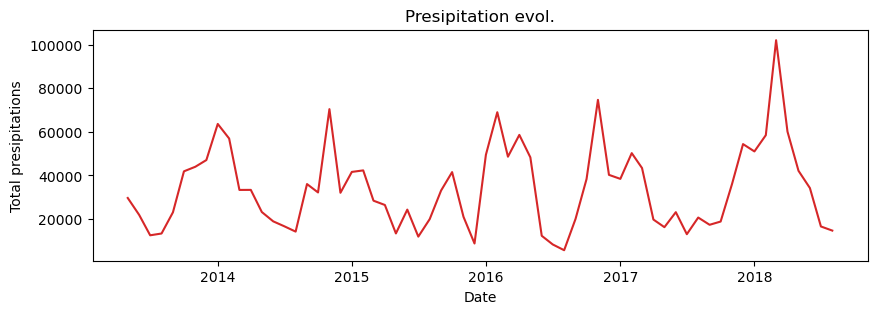

In [14]:
plot_df(data.index, data['rain_all'], 'Presipitation evol.')

There is a slight upward trend, no clear/defined seasonality pattern, although there are some spikes in precipitation around the turn of the year, which is natural for the rainy time of the year.

In [15]:
data_boxplot=data.copy()
data_boxplot.reset_index(inplace=True)
data_boxplot.head()

,new_date,rain_all
0,2013-05-01,29634.3
1,2013-06-01,21886.2
2,2013-07-01,12508.8
3,2013-08-01,13331.8
4,2013-09-01,23053.8


In [16]:
data_boxplot['year']=[d.year for d in data_boxplot.new_date]
data_boxplot['month']=[d.strftime('%b') for d in data_boxplot.new_date]
data_boxplot.head()

,new_date,rain_all,year,month
0,2013-05-01,29634.3,2013,May
1,2013-06-01,21886.2,2013,Jun
2,2013-07-01,12508.8,2013,Jul
3,2013-08-01,13331.8,2013,Aug
4,2013-09-01,23053.8,2013,Sep


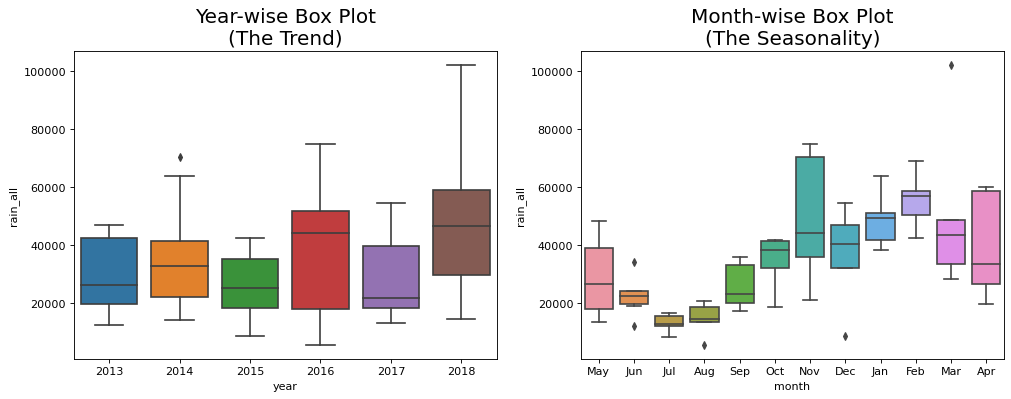

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), dpi= 80)
sns.boxplot(x='year', y='rain_all', data=data_boxplot, ax=axes[0])
sns.boxplot(x='month', y='rain_all', data=data_boxplot, ax=axes[1])

axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

The Year-wise boxplot confirms what has been said in relation to the trend. In the case of Month-wise the same as above.

Despite this visualisation, we are not able to determine exactly whether the model is additive or multiplicative. Still, we can, from indications, try to advance the conclusion.

Looking at the growth of the variance (boxplot Year-wise), it is apparently exponential from 2015 onwards, with the exception of 2017 when the variance falls again. This could indicate that it is a multiplicative model.

To draw a concrete conclusion we have to use seasonal_decompose, which is the method dealt with in the next point, so we continue with point 3, and answer the type of model at the end of it.

### 4.3. Decompose in trend, seasonal and noise components

We plot, initially assuming an additive model, then a multiplicative model.

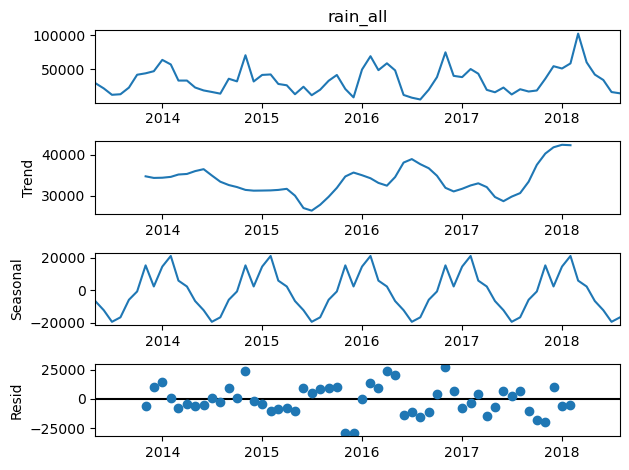

In [18]:
data_add=seasonal_decompose(data['rain_all'], model='additive')
data_add.plot();

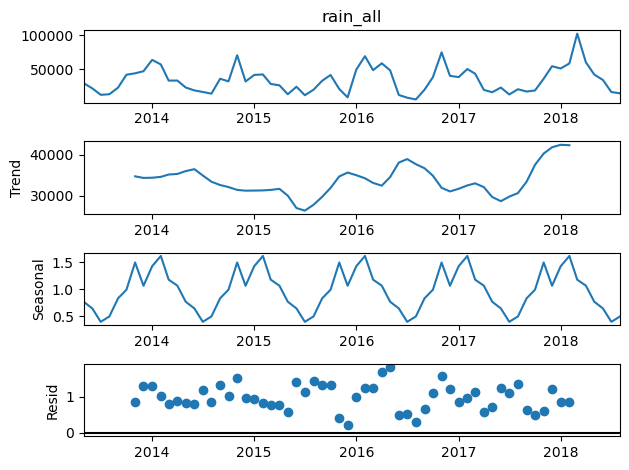

In [19]:
data_mul=seasonal_decompose(data['rain_all'], model='multiplicative')
data_mul.plot();

Neither model shows any remaining patterns in the residual plot, which would indicate which one fits less and is therefore discarded.

Analyse the histogram, mean and standard deviation.

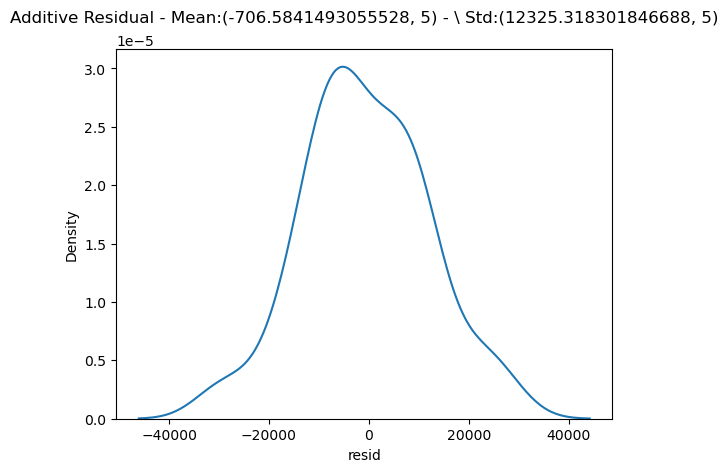

In [20]:
sns.kdeplot(data_add.resid)
plt.title(f"Additive Residual - Mean:{data_add.resid.mean(), 5} - \ Std:{data_add.resid.std(), 5}", pad=20);

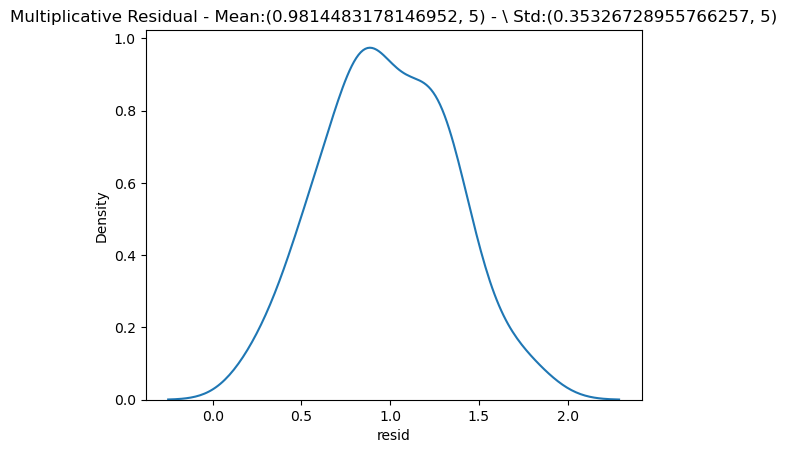

In [21]:
sns.kdeplot(data_mul.resid)
plt.title(f"Multiplicative Residual - Mean:{data_mul.resid.mean(), 5} - \ Std:{data_mul.resid.std(), 5}");

The multiplicative model curve is slightly better (closer to a Gaussian bell), and more importantly. The standard deviation is lower, which leads us to interpret that it represents less variability, which has remained in the trend and seasonality components, to better explain these components of the series.

The series follows a multiplicative model.

### 4.4. Stationary analysis

* Visual analysis
* Moving statistical parameters
* Autocorrelation
* Hypothesis testing

__Method 1__: visual analysis

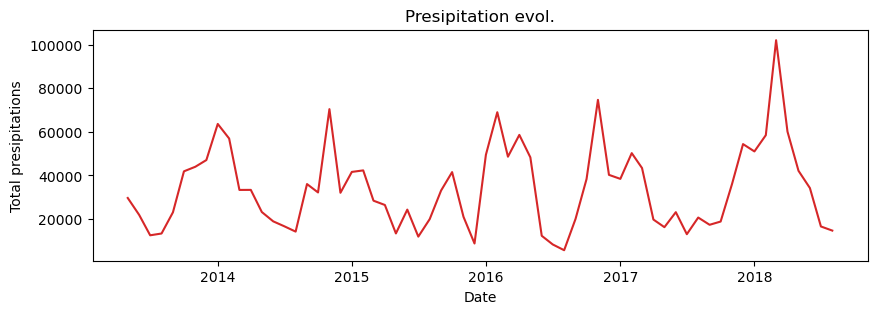

In [22]:
plot_df(data.index, data['rain_all'], 'Presipitation evol.')

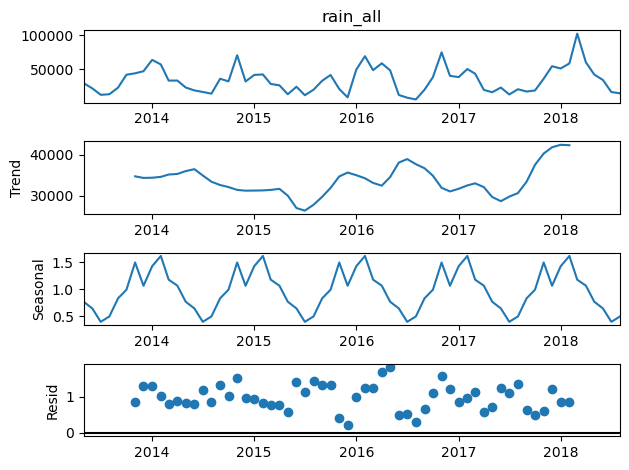

In [23]:
data_mul=seasonal_decompose(data['rain_all'], model='multiplicative')
data_mul.plot();

As we can see, the graph has both a trend component (fluctuating) and a seasonality component. Therefore, according to the visual analysis, the series is NON-stationary.

__Method 2__: moving statistical parameters

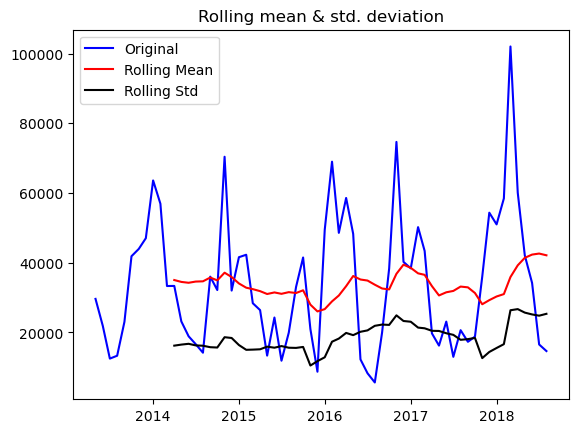

In [24]:
test_stationarity(data['rain_all'], 12)

Next we will complement the previous graph by separating the series into 2 halves and comparing the mean and variance of both halves.

In [25]:
split = round(len(data['rain_all'])/2)
split

32

In [26]:
new_ts1, new_ts2 = data['rain_all'].values[0:split], data['rain_all'].values[split:]

In [27]:
print('mean_1 = %f, mean_2 = %f' %(new_ts1.mean(), new_ts2.mean()))
print('var_1 = %f, var_2 = %f' %(new_ts1.var(), new_ts2.var()))

mean_1 = 30516.615625, mean_2 = 37618.412500
var_1 = 224374870.033193, var_2 = 481174784.897968


The graph shows that both the mean and the standard deviation oscillate throughout the series. At the same time we see that both the mean and mainly the variance are clearly different in both halves of the series. It is again concluded that the series is NON-stationary.

__Method 3__: autocorrelation

In [28]:
data['rain_all'].autocorr()

0.5747791676202648

We can see that there is a positive correlation with itself (lag=1), which means that we can already see that this series is NON-stationary. We now analyse the correlogram to see the relationship between its components.

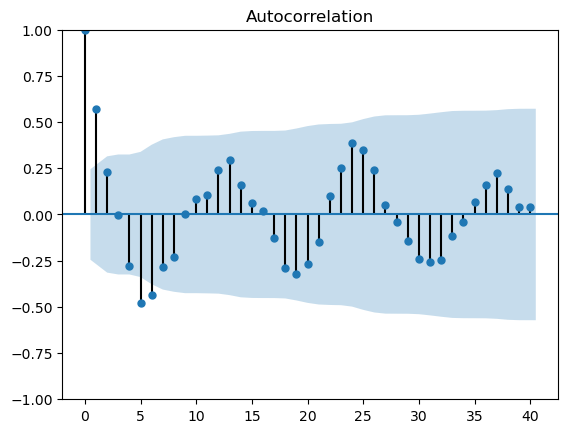

In [29]:
plot_acf(data['rain_all'],lags=40);

We see correlation (points exceeding the confidence interval band, default 95%) between Xt with Xt-1, Xt-5 and Xt-6.

Being a series with monthly data, the fact that there is a negative correlation with Xt-5 and Xt-6 is logical, given that 6 months separate summer from winter, i.e. the months with less precipitation with respect to those with more precipitation. All of them in a fluctuating cycle/period (positive and negative) and repetitive of 12 months.

__Method 4__: hypothesis testing

In [30]:
interpret_dftest(data['rain_all'], 0.05)

ADF Statistic: -5.477654
p-value: 0.000002
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594
We can reject the null hypothesis. Time series is stationary.


We see that according to the unit root test (Dickey-Fuller), the series is stationary. However, the other three methods indicate the opposite, so we estimate that the series is NON-stationary.

At this point we will apply different tools to obtain a series that IS stationary.

We have a series with a very clear seasonal pattern, so we will start by applying the differentiation method.

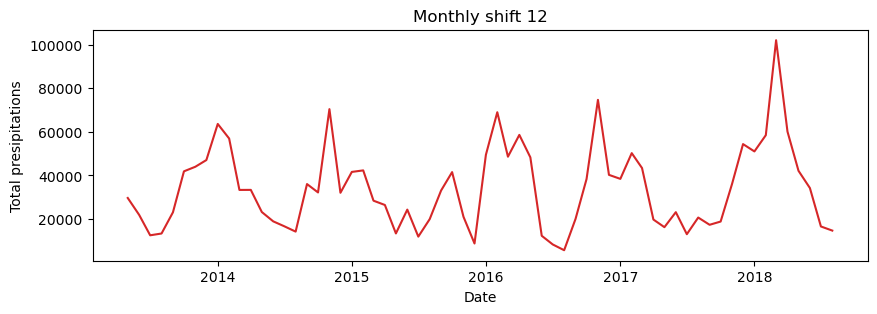

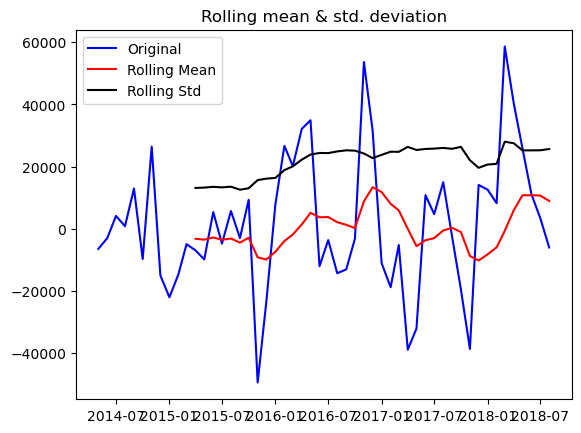

ADF Statistic: -2.886931
p-value: 0.046889
Critical Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607
Time series is not stationary.


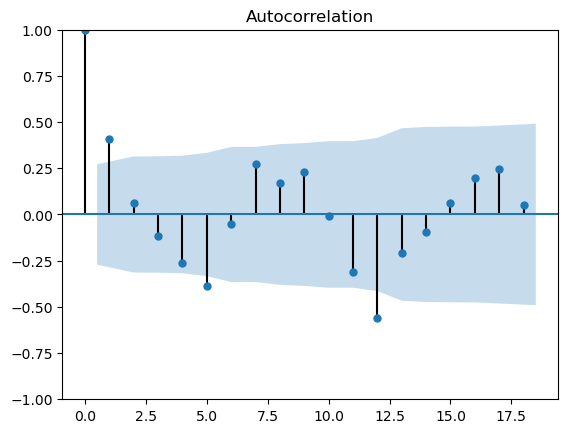

In [31]:
data['rain_all_diff'] = data['rain_all'] - data['rain_all'].shift(12)

# Battery of tests
plot_df(x=data.index, y=data.rain_all, title='Monthly shift 12')
test_stationarity(data['rain_all_diff'], 12)
plot_acf(data['rain_all_diff'].dropna());
interpret_dftest(data['rain_all_diff'].dropna(), 0.05)

It remains NON-stationary. We apply, in combination, base 10 logarithm and deferencing of Xt-1.

In [32]:
data['log_value'] = np.log(data['rain_all'])

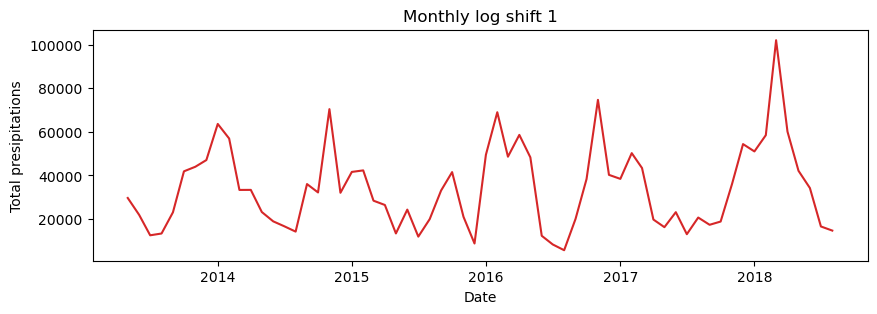

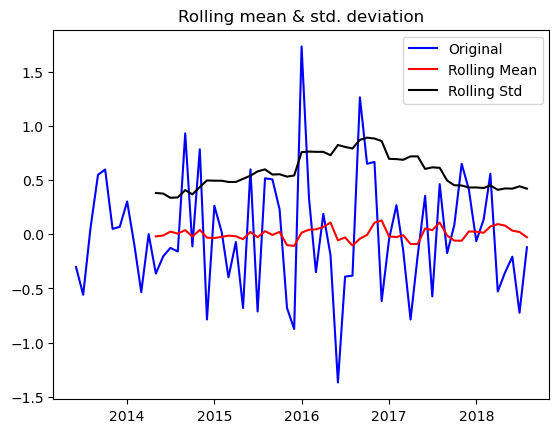

ADF Statistic: -5.060807
p-value: 0.000017
Critical Values:
	1%: -3.566
	5%: -2.920
	10%: -2.598
We can reject the null hypothesis. Time series is stationary.


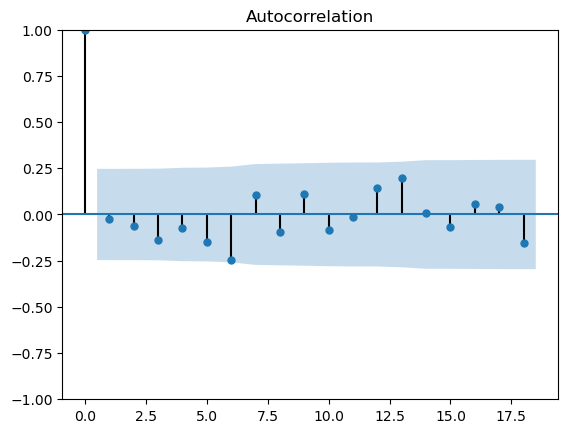

In [33]:
data['rain_all_log_diff'] = data['log_value'] - data['log_value'].shift(1)

# Battery of tests
plot_df(x=data.index, y=data.rain_all, title='Monthly log shift 1')
test_stationarity(data['rain_all_log_diff'], 12)
plot_acf(data['rain_all_log_diff'].dropna());
interpret_dftest(data['rain_all_log_diff'].dropna(), 0.05)

We see that the visual method, autoregression and the unit root test show a behaviour that could be identified as stationary. We will apply, in combination, square root logarithm and Xt-1 deferencing to try to improve the behaviour.

In [34]:
data['sqrt_value'] = np.sqrt(data['rain_all'])

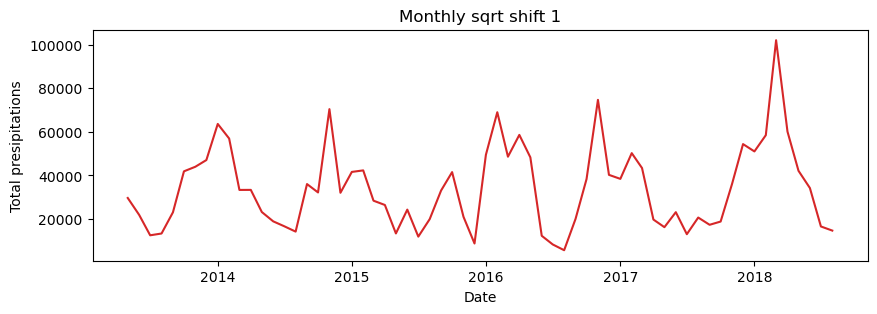

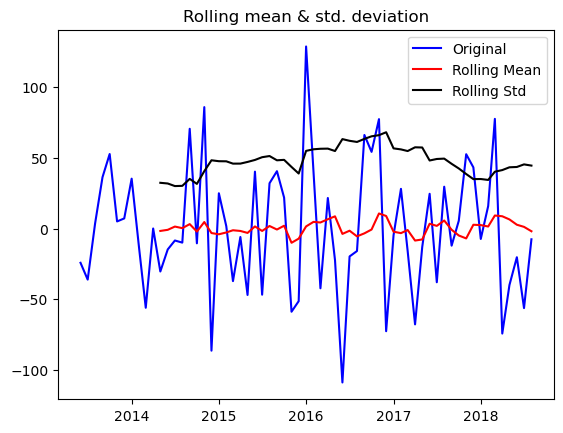

ADF Statistic: -5.633663
p-value: 0.000001
Critical Values:
	1%: -3.563
	5%: -2.919
	10%: -2.597
We can reject the null hypothesis. Time series is stationary.


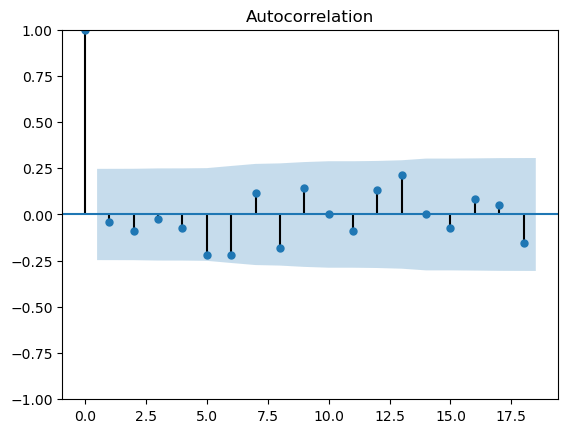

In [35]:
data['rain_all_sqrt_diff'] = data['sqrt_value'] - data['sqrt_value'].shift(1)

# Aplicamos la batería de comprobaciones
plot_df(x=data.index, y=data.rain_all, title='Monthly sqrt shift 1')
test_stationarity(data['rain_all_sqrt_diff'], 12)
plot_acf(data['rain_all_sqrt_diff'].dropna());
interpret_dftest(data['rain_all_sqrt_diff'].dropna(), 0.05)

We see that the conclusions are the same, but we have improved the results. The margin between ADF and critical values has widened, and in the autocorrelation plot Xt-5 is clearly within the confidence threshold.

After the transformations, the time serie IS stationary.

## 5. Train model

### 5.1. Benchmark

In [36]:
data.tail(12)

,rain_all,rain_all_diff,log_value,rain_all_log_diff,sqrt_value,rain_all_sqrt_diff
new_date,,,,,,
2017-09-01,17329.0,-2690.0,9.760137,-0.175547,131.639660,-12.076728
2017-10-01,18820.2,-19511.0,9.842686,0.082549,137.186734,5.547074
2017-11-01,36033.6,-38623.7,10.492207,0.649521,189.825183,52.638449
2017-12-01,54357.4,14110.9,10.903336,0.411129,233.146735,43.321552
2018-01-01,50999.6,12599.3,10.839573,-0.063763,225.830910,-7.315825
2018-02-01,58450.3,8235.9,10.975932,0.136359,241.764969,15.934058
2018-03-01,102026.0,58651.2,11.532983,0.557051,319.415090,77.650122
2018-04-01,60092.5,40356.1,11.003640,-0.529343,245.137716,-74.277374
2018-05-01,42106.1,25868.1,10.647948,-0.355692,205.197710,-39.940007


In [37]:
data_train=data[:-12]
data_test=data[-12:]
data_train.shape, data_test.shape

((52, 6), (12, 6))

In [38]:
data_train.tail(1)

,rain_all,rain_all_diff,log_value,rain_all_log_diff,sqrt_value,rain_all_sqrt_diff
new_date,,,,,,
2017-08-01,20654.4,14993.7,9.935684,0.46188,143.716387,29.636152


In [39]:
data_test.head(1)

,rain_all,rain_all_diff,log_value,rain_all_log_diff,sqrt_value,rain_all_sqrt_diff
new_date,,,,,,
2017-09-01,17329.0,-2690.0,9.760137,-0.175547,131.63966,-12.076728


We then apply four models:

* Mean of the time series
* Average of the last N periods
* Last naive value
* The last periodic or seasonal naive pattern

They will be applied on the original variable "rain_all", since these models and their prediction are not affected by the stationary condition of the series.

* Mean of the time series

In [40]:
data_test = data_test.assign(y_hat_mean=data_train['rain_all'].mean())

* Average of the last N periods

In [41]:
data_test = data_test.assign(y_hat_mean_last_n=data_train['rain_all'].rolling(N).mean().iloc[-1])

* Last naive value

In [42]:
data_test = data_test.assign(y_hat_naive=data_train['rain_all'].iloc[-1])

* Seasonal naive

In [43]:
data_test = data_test.assign(y_hat_naive_seasonal=data_train['rain_all'].iloc[-12:].values)

In [44]:
data_test.head()

,rain_all,rain_all_diff,log_value,rain_all_log_diff,sqrt_value,rain_all_sqrt_diff,y_hat_mean,y_hat_mean_last_n,y_hat_naive,y_hat_naive_seasonal
new_date,,,,,,,,,,
2017-09-01,17329.0,-2690.0,9.760137,-0.175547,131.639660,-12.076728,32205.223077,33167.333333,20654.4,20019.0
2017-10-01,18820.2,-19511.0,9.842686,0.082549,137.186734,5.547074,32205.223077,33167.333333,20654.4,38331.2
2017-11-01,36033.6,-38623.7,10.492207,0.649521,189.825183,52.638449,32205.223077,33167.333333,20654.4,74657.3
2017-12-01,54357.4,14110.9,10.903336,0.411129,233.146735,43.321552,32205.223077,33167.333333,20654.4,40246.5
2018-01-01,50999.6,12599.3,10.839573,-0.063763,225.830910,-7.315825,32205.223077,33167.333333,20654.4,38400.3


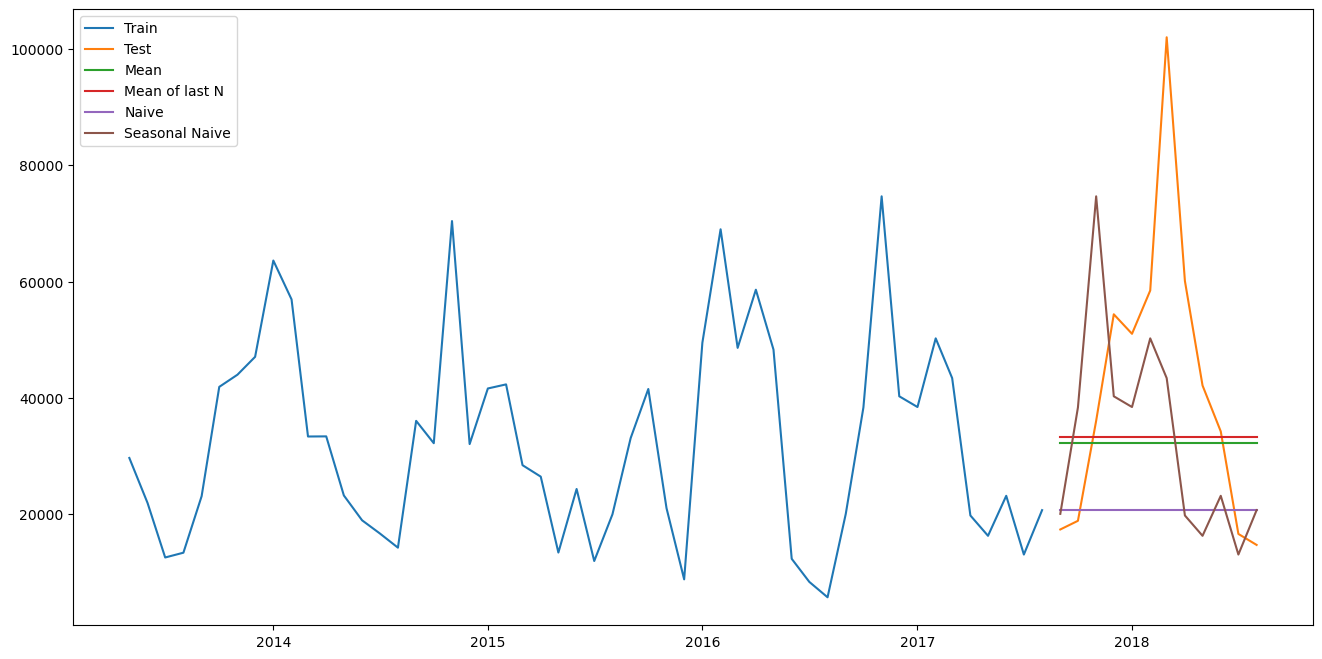

In [45]:
plt.figure(figsize=(16,8))
plt.plot(data_train['rain_all'], label='Train')
plt.plot(data_test['rain_all'], label='Test')
plt.plot(data_test['y_hat_mean'], label='Mean')
plt.plot(data_test['y_hat_mean_last_n'], label='Mean of last N')
plt.plot(data_test['y_hat_naive'], label='Naive')
plt.plot(data_test['y_hat_naive_seasonal'], label='Seasonal Naive')
plt.legend(loc='best')
plt.show()

None of the benchmark models approximate, in their predictions, the original/actual series, represented by test.
Taking into account the seasonal component, the best approximating model is the Seasonal Naive.

In the following we will check the goodness of fit of the best approximating model according to the visual check: Seasonal Naive.

In [46]:
forecast_accuracy(data_test['y_hat_naive_seasonal'],data_test['rain_all'])

{'me': -8970.108333333332,
 'mae': 20104.975000000002,
 'mape': 0.4765227685594149,
 'rmse': 26163.48706265088}

Taking the MAPE value, which is abstracted from the scale of the data, providing a percentage value. We see that the Seasonal_Naive model has an error of 47%, an unacceptable level, far from 20% to be considered a good model.

### 5.2. AR or MA

We will check whether an AR or MA model is appropriate on the basis of the ACF and PACF graphs.

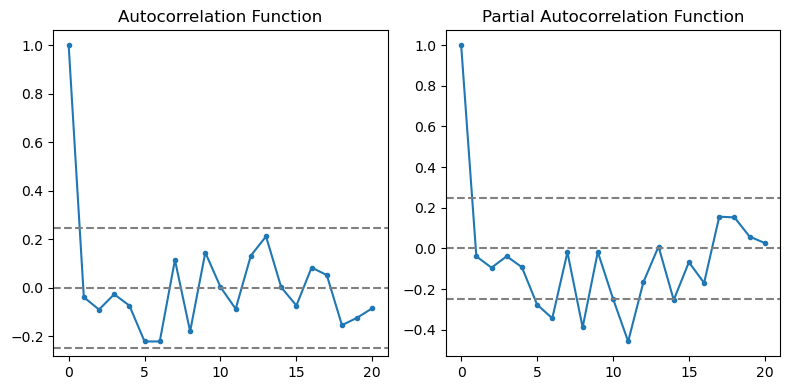

In [47]:
obtain_order_model(data['rain_all_sqrt_diff'].dropna(), 0.05)

We see that none of the curves decay smoothly, nor does PACF show a cross-sign fading. Therefore, it is very likely that our series has an ARMA behaviour at least.

In any case, we will check the goodness of fit of the AR and MA model separately, and then jointly.

To do this, we will start with the simplest type 1 models and then:
* p(AR): according to PACF, exceeding the confidence threshold, we have Xt-5, Xt-6, Xt-8, Xt-12.
* q(MA): according to ACF, this time Xt-5 and Xt-6 close to the interval, we will use them.

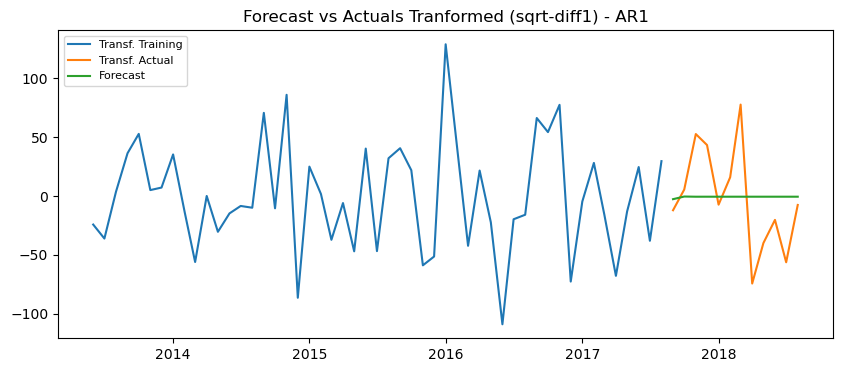

{'me': 1.1571340239677934, 'mae': 34.118219157719544, 'mape': 0.9758717791761774, 'rmse': 42.66038640125477}
                               SARIMAX Results                                
Dep. Variable:     rain_all_sqrt_diff   No. Observations:                   51
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -268.005
Date:                Wed, 22 Mar 2023   AIC                            542.010
Time:                        22:26:54   BIC                            547.805
Sample:                    06-01-2013   HQIC                           544.224
                         - 08-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5624      6.205     -0.091      0.928     -12.724      11.599
ar.L1         -0.0695 

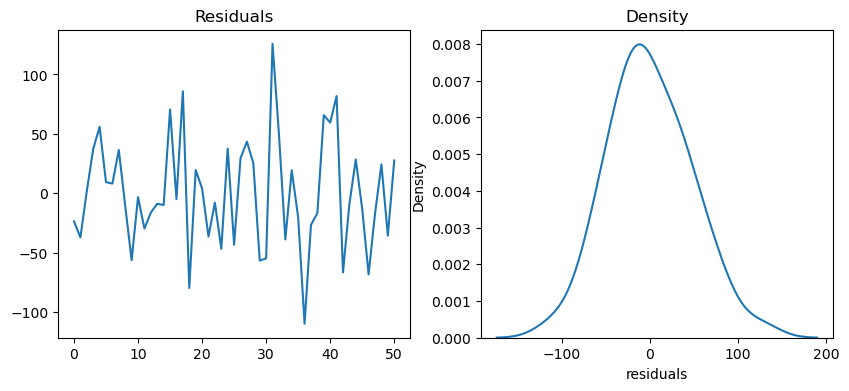

In [48]:
model_ar = ARIMA(data_train['rain_all_sqrt_diff'].dropna(), order=(1, 0, 0), freq='MS')  
model_ar_fitted = model_ar.fit()
forecasting_arma(model_ar_fitted, N, data_test, 'Forecast vs Actuals Tranformed (sqrt-diff1) - AR1')
model_summary_results(model_ar_fitted)

It can be seen that the p-value of the AR component is greater than 0.05. It is therefore not significant. We take the AIC value as a reference to follow its evolution (542), we also observe that the MAPE value is 97% error and we observe that visually the behaviour of the residual is random and follows a Gaussian bell in its distribution, however, according to the Ljung-Box test (h0=the residuals are distributed independently) with a p-value of 0.95, it seems to indicate that there are components that contain a correlation, with which the information of the model has been collected in it.

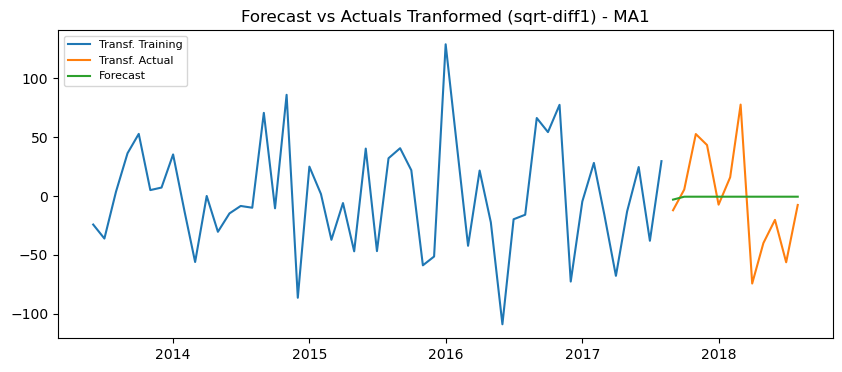

{'me': 1.1187230228135878, 'mae': 34.09856613419894, 'mape': 0.9754782724807645, 'rmse': 42.654356062937715}
                               SARIMAX Results                                
Dep. Variable:     rain_all_sqrt_diff   No. Observations:                   51
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -267.967
Date:                Wed, 22 Mar 2023   AIC                            541.934
Time:                        22:26:55   BIC                            547.729
Sample:                    06-01-2013   HQIC                           544.148
                         - 08-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5576      6.040     -0.092      0.926     -12.395      11.280
ma.L1         -0.0921 

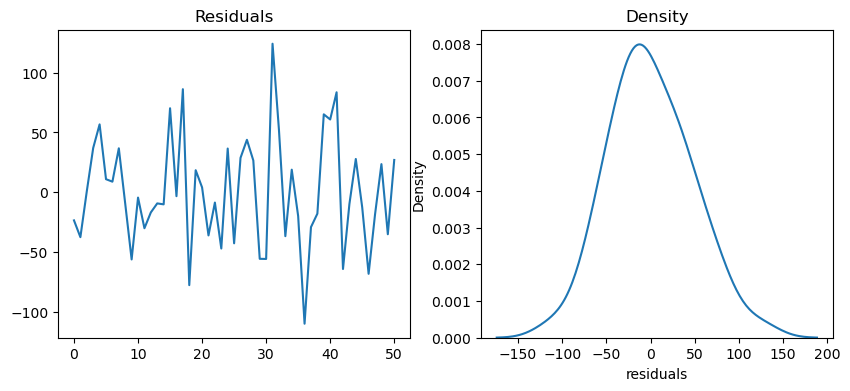

In [49]:
model_ma= ARIMA(data_train['rain_all_sqrt_diff'].dropna(), order=(0, 0, 1), freq='MS')  
model_ma_fitted = model_ma.fit()
forecasting_arma(model_ma_fitted, N, data_test, 'Forecast vs Actuals Tranformed (sqrt-diff1) - MA1')
model_summary_results(model_ma_fitted)

It can be seen that the p-value of the MA component is greater than 0.05. It is therefore not significant. The conclusions are the same as in the previous model, but the goodness of fit (AIC and p-value of ma.L1) is improved.

C:\Users\joaqu\anaconda3\envs\Data_Science\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\joaqu\anaconda3\envs\Data_Science\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


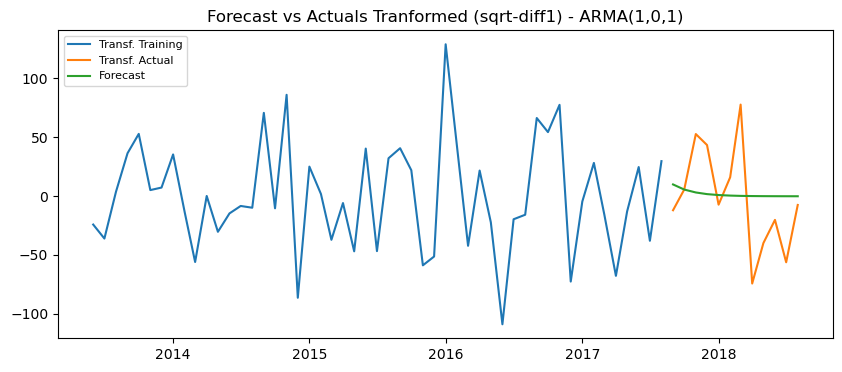

{'me': 3.615611259300526, 'mae': 34.348975382145056, 'mape': 0.9817454067500838, 'rmse': 42.52870540472536}
                               SARIMAX Results                                
Dep. Variable:     rain_all_sqrt_diff   No. Observations:                   51
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -263.009
Date:                Wed, 22 Mar 2023   AIC                            534.018
Time:                        22:26:55   BIC                            541.746
Sample:                    06-01-2013   HQIC                           536.971
                         - 08-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2015      0.874     -0.230      0.818      -1.915       1.512
ar.L1          0.5672  

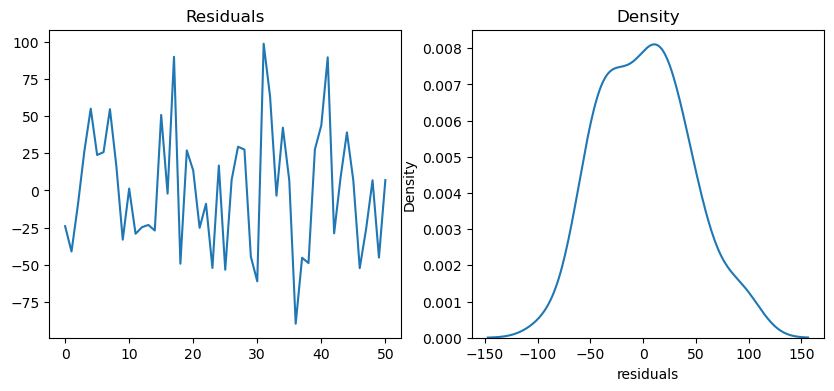

In [50]:
model_arma= ARIMA(data_train['rain_all_sqrt_diff'].dropna(), order=(1, 0, 1), freq='MS')  
model_arma_fitted = model_arma.fit()
forecasting_arma(model_arma_fitted, N, data_test, 'Forecast vs Actuals Tranformed (sqrt-diff1) - ARMA(1,0,1)')
model_summary_results(model_arma_fitted)

MAPE worsens by half a point to 98%. The AR component is significant and the AIC value drops to 534. The Ljung-Box test, although it has improved, the value does not allow the null hypothesis to be rejected, so the error would still contain correlation.

C:\Users\joaqu\anaconda3\envs\Data_Science\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\joaqu\anaconda3\envs\Data_Science\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


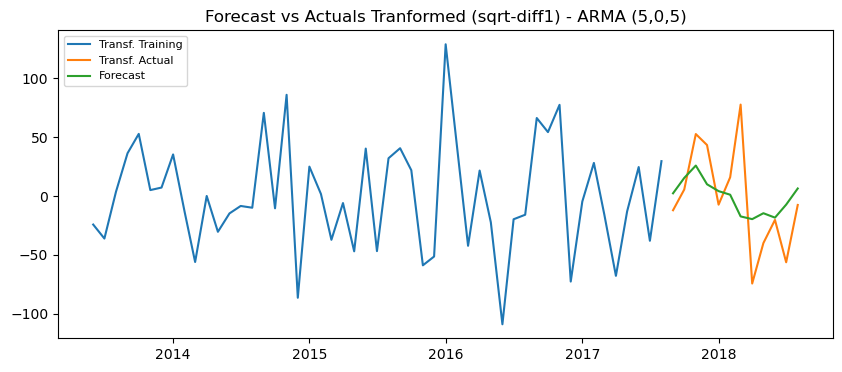

{'me': 0.8977618476665956, 'mae': 29.2049893261488, 'mape': 1.0123962304766618, 'rmse': 38.4347202462549}
                               SARIMAX Results                                
Dep. Variable:     rain_all_sqrt_diff   No. Observations:                   51
Model:                 ARIMA(5, 0, 5)   Log Likelihood                -253.321
Date:                Wed, 22 Mar 2023   AIC                            530.641
Time:                        22:26:56   BIC                            553.823
Sample:                    06-01-2013   HQIC                           539.500
                         - 08-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3446      0.453     -0.761      0.447      -1.232       0.543
ar.L1          0.9913    

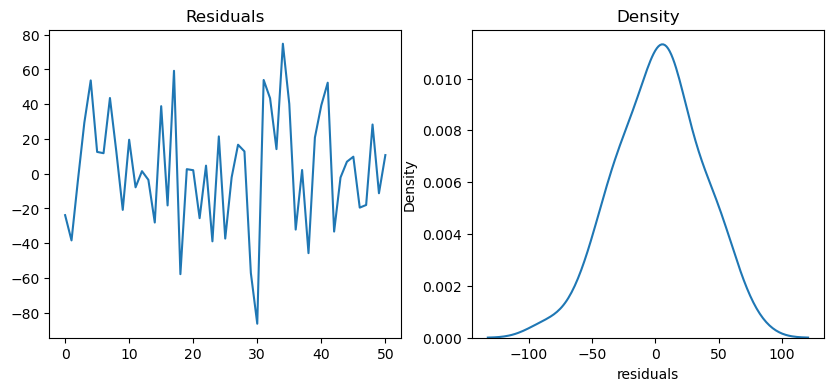

In [51]:
model_arma_2= ARIMA(data_train['rain_all_sqrt_diff'].dropna(), order=(5, 0, 5), freq='MS')  
model_arma_2_fitted = model_arma_2.fit()
forecasting_arma(model_arma_2_fitted, N, data_test, 'Forecast vs Actuals Tranformed (sqrt-diff1) - ARMA (5,0,5)')
model_summary_results(model_arma_2_fitted)

On the other hand, we use a component p(AR)=5 and q(MA)=5. Values chosen in relation to the highly correlated components, observed in the correlogram run on the transformed data.

We continue to improve the parameters (AIC=530 and visual analysis: apparently we see that the prediction tries to follow the silhouette of the real series), however, only the ar.L1 component is significant and the noise, according to the Ljung-Box test, continues to pick up correlation.

If we review the value of the components, we can see that even if we add a higher number/degree, the ARMA model will not improve, as it is not possible to make an individual selection of components to keep. And being only and at all times significant or close to it, the ar.L1 component.

A sample of the above. This more complex model is the one that reflects the worst MAPE parameter (101% error).

### 5.3. ARIMA or SARIMA

C:\Users\joaqu\anaconda3\envs\Data_Science\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\joaqu\anaconda3\envs\Data_Science\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\joaqu\anaconda3\envs\Data_Science\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


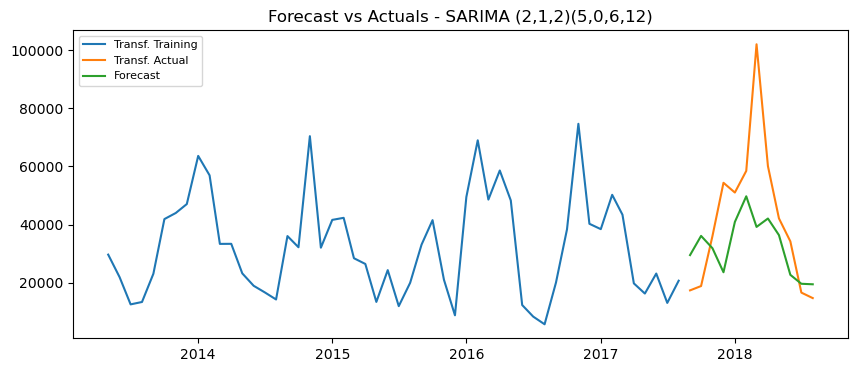

{'me': -9568.894183667258, 'mae': 15767.043347172812, 'mape': 0.3788096884868939, 'rmse': 22477.54367465609}
                                             SARIMAX Results                                             
Dep. Variable:                                          rain_all   No. Observations:                   52
Model:             ARIMA(2, 1, 2)x(5, 0, [1, 2, 3, 4, 5, 6], 12)   Log Likelihood                -560.644
Date:                                           Wed, 22 Mar 2023   AIC                           1153.288
Time:                                                   22:27:03   BIC                           1184.197
Sample:                                               05-01-2013   HQIC                          1165.100
                                                    - 08-01-2017                                         
Covariance Type:                                             opg                                         
                 coef    std err          z

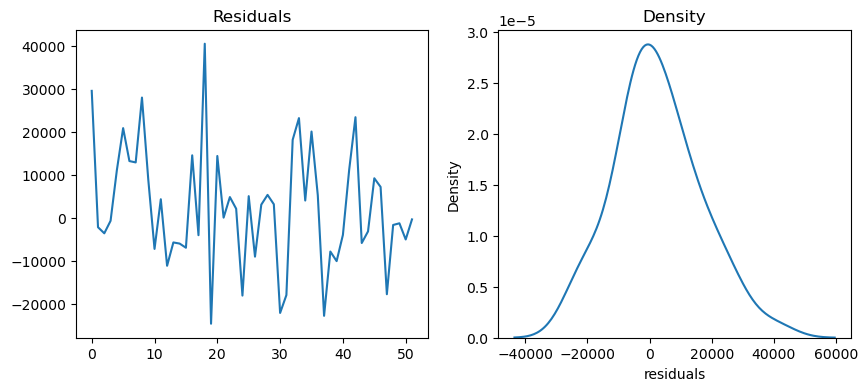

In [52]:
model_sarima= ARIMA(data_train['rain_all'], order=(2, 1, 2), freq='MS', seasonal_order= (5,0,6,12))  
model_sarima_fitted = model_sarima.fit()
forecasting_arima(model_sarima_fitted, N, data_test, 'Forecast vs Actuals - SARIMA (2,1,2)(5,0,6,12)')
model_summary_results(model_sarima_fitted)

In this case we force the d (degree of differencing) component to 1, in this way we work against the original training series, since the model itself, by means of differencing, transforms the series into a stationary one.

On the other hand, when using a SARIMA model, we overturn the seasonality indices that we used in the ARMA model and that we extracted from the correlograms: p(AR)=5 and 1(MA)=5 to define the seasonality parameters P and Q (P,D,Q,M). Thus the model chosen is a (2,1,2) (5,0,6,12). Being M=12, the seasonality/period of our data.

With this version of ARIMA, we manage to reduce the MAPE error to 38%, although according to AIC (1153) none of the components of the model are significant and we continue to contain autocorrelation in the residual.

### 5.4. auto ARIMA

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1139.160, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1141.997, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1144.792, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1144.528, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1140.013, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1137.974, Time=0.27 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1138.892, Time=0.19 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=1137.019, Time=0.51 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=1135.109, Time=0.32 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=1139.643, Time=0.10 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1139.266, Time=0.10 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=1136.541, Time=0.44 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=1140.573, Time=0.16 sec
 ARIMA(0,1,0)(2,0,0)[12]

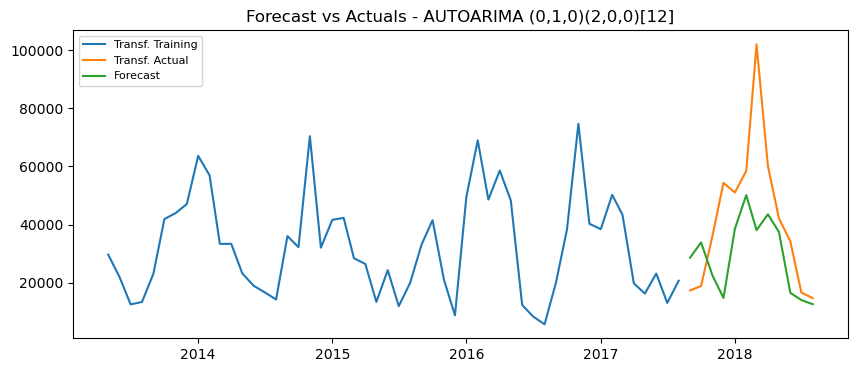

{'me': -12953.10945834447, 'mae': 17330.675135937236, 'mape': 0.3977213263564264, 'rmse': 24234.09670816841}
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   52
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 12)   Log Likelihood                -563.576
Date:                            Wed, 22 Mar 2023   AIC                           1133.152
Time:                                    22:27:10   BIC                           1138.947
Sample:                                05-01-2013   HQIC                          1135.366
                                     - 08-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.

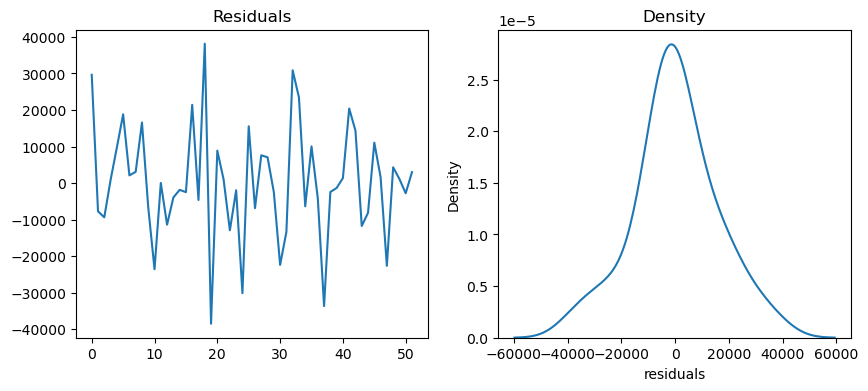

In [53]:
model_autoarima_fitted = pm.auto_arima(data_train.rain_all, 
                                start_p=1, start_q=1, 
                                test='adf',           
                                max_p=12, max_q=12,   
                                m=12,                 
                                d=1,                  
                                seasonal=True,        
                                start_P=0,
                                D=0,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)
forecasting_autoarima(model_autoarima_fitted, N, data_test, 'Forecast vs Actuals - AUTOARIMA (0,1,0)(2,0,0)[12]')
model_summary_results_autoarima(model_autoarima_fitted)

In this case we force the d (degree of differencing) component to 1, in this way we work against the original input series, and we do not run the risk of using these data (the originals) automatically modelling AR, MA or ARMA models, the original series being NON-stationary.

We find that we obtain the minimum MAPE value obtained so far (39.7% error), the AIC value is higher than those obtained in simpler models (534). The ar.L1 component is again the only significant one, and we continue to have autocorrelation in the residual.

### 5.5. Prophet

In [54]:
data_train_prophet=data_train[['rain_all']].reset_index().rename(columns={'new_date': 'ds',
                            'rain_all': 'y'})

In [55]:
model_prophet = Prophet(interval_width=0.95,
                            seasonality_mode='multiplicative',
                            yearly_seasonality = True,
                            weekly_seasonality = True,
                            daily_seasonality = False)

In [56]:
model_prophet.fit(data_train_prophet)

In [57]:
future_dates = model_prophet.make_future_dataframe(periods=12, freq='MS')

In [58]:
forecast = model_prophet.predict(future_dates)

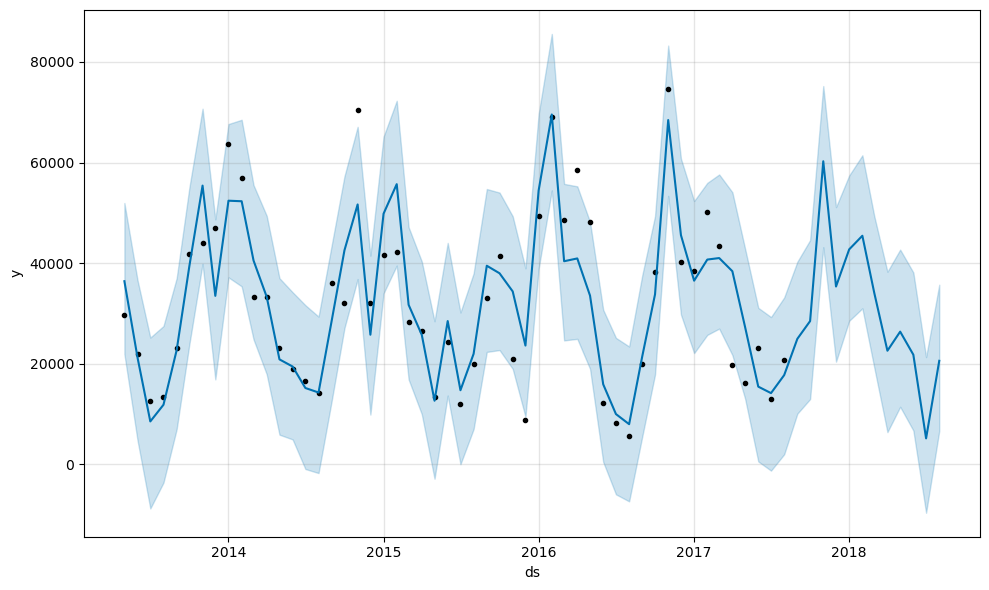

In [59]:
model_prophet.plot(forecast, uncertainty=True);

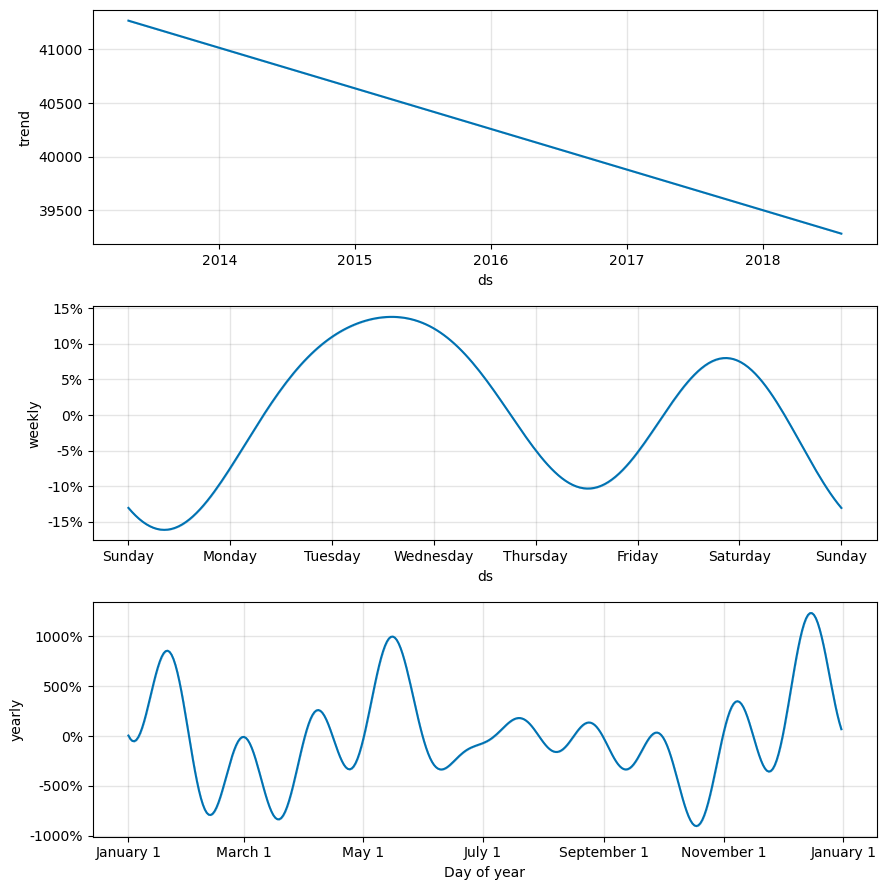

In [60]:
model_prophet.plot_components(forecast);

For metrics we will focus on the calculation according to our Accuracy function that we defined at the beginning of the exercise and in which the MAPE value is extracted. Error/bonus reference of the model used during the whole development.

We will extract from the Prophet model the series of the last 12 values to cross-check them with our data_test.
We check that there are no overlaps

In [61]:
data_pred_prophet=forecast[['ds','yhat']].tail(12).copy()
data_pred_prophet.set_index('ds',drop=True, inplace=True)
data_pred_prophet=data_pred_prophet.squeeze()

In [62]:
forecast_accuracy(data_pred_prophet,data_test.rain_all)

{'me': -11484.395380808228,
 'mae': 19388.63944407616,
 'mape': 0.4564428356727593,
 'rmse': 25697.416070956177}

Finally note that the MAPE value is 45% error.

## 6. Best model

So far, and as mentioned at the end of the previous section, we will focus on the MAPE value to assess the goodness of fit of the model.

We will then construct a comparative table.

In [63]:
#Benchmarching
data_bench_acc=pd.DataFrame.from_dict(forecast_accuracy(data_test.y_hat_naive_seasonal,data_test.rain_all), 
                                      orient='index', columns=['Mod. Bench'])
#AR
data_ar_acc=pd.DataFrame.from_dict(forecast_accuracy(model_ar_fitted.forecast(N, alpha=0.05),data_test.rain_all_sqrt_diff),
                                   orient='index', columns=['Mod. AR'])
#MA
data_ma_acc=pd.DataFrame.from_dict(forecast_accuracy(model_ma_fitted.forecast(N, alpha=0.05),data_test.rain_all_sqrt_diff),
                                    orient='index', columns=['Mod. MA'])
#ARMA
data_arma_acc=pd.DataFrame.from_dict(forecast_accuracy(model_arma_fitted.forecast(N, alpha=0.05),data_test.rain_all_sqrt_diff),
                                     orient='index', columns=['Mod. ARMA'])
#ARMA 2
data_arma_2_acc=pd.DataFrame.from_dict(forecast_accuracy(model_arma_2_fitted.forecast(N, alpha=0.05),data_test.rain_all_sqrt_diff),
                                       orient='index', columns=['Mod. ARMA 2'])
#SARIMA
data_sarima_acc=pd.DataFrame.from_dict(forecast_accuracy(model_sarima_fitted.forecast(N, alpha=0.05),data_test.rain_all),
                                       orient='index', columns=['Mod. SARIMA'])
#autoARIMA
data_autoarima_acc=pd.DataFrame.from_dict(forecast_accuracy(model_autoarima_fitted.predict(N, alpha=0.05),data_test.rain_all),
                                          orient='index', columns=['Mod. AUTOARIMA'])
#Prophet
data_prophet_acc=pd.DataFrame.from_dict(forecast_accuracy(data_pred_prophet,data_test.rain_all),
                                        orient='index', columns=['Mod. PROPHET'])

In [64]:
summary_acc=pd.concat([data_bench_acc,data_ar_acc,data_ma_acc,data_arma_acc,data_arma_2_acc,data_sarima_acc,data_autoarima_acc,data_prophet_acc],axis=1)
summary_acc

,Mod. Bench,Mod. AR,Mod. MA,Mod. ARMA,Mod. ARMA 2,Mod. SARIMA,Mod. AUTOARIMA,Mod. PROPHET
me,-8970.108333,1.157134,1.118723,3.615611,0.897762,-9568.894184,-12953.109458,-11484.395381
mae,20104.975000,34.118219,34.098566,34.348975,29.204989,15767.043347,17330.675136,19388.639444
mape,0.476523,0.975872,0.975478,0.981745,1.012396,0.378810,0.397721,0.456443
rmse,26163.487063,42.660386,42.654356,42.528705,38.434720,22477.543675,24234.096708,25697.416071


In [65]:
summary_acc.loc['mape']==summary_acc.loc['mape'].min()

Mod. Bench        False
Mod. AR           False
Mod. MA           False
Mod. ARMA         False
Mod. ARMA 2       False
Mod. SARIMA        True
Mod. AUTOARIMA    False
Mod. PROPHET      False
Name: mape, dtype: bool

In [66]:
'The best model obtained is SARIMA with a MAPE value = {}% error.'.format(round(summary_acc.loc['mape'].min(),3)*100)

'The best model obtained is SARIMA with a MAPE value = 37.9% error.'

We can see that we are well above the 20% limit, which in our opinion is the maximum level of error to be considered a "good model".

Also, as an extra conclusion, automatic models don't always generate the best models, as long as we have enough time, it is convenient to perform manual variations, in search of better results.